<a href="https://colab.research.google.com/github/AlmTechSoftware/piper/blob/research/training_data/research/feynman_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

## Dataset download from temporary 0x0.st

In [1]:
!curl http://0x0.st/HLtv.zip > dataset.zip
!rm -r dataset
!unzip dataset.zip -d dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.1M  100 12.1M    0     0  5038k      0  0:00:02  0:00:02 --:--:-- 5038k
Archive:  dataset.zip
 extracting: dataset/README.dataset.txt  
 extracting: dataset/README.roboflow.txt  
   creating: dataset/test/
 extracting: dataset/test/Adam-still_jpeg.rf.90fbaea30ed3e09fd7fda5aa92ea6a68.jpg  
 extracting: dataset/test/Adam-still_jpeg.rf.90fbaea30ed3e09fd7fda5aa92ea6a68_mask.png  
 extracting: dataset/test/Board_jpg.rf.4d5d6a6f3c89eab87661fa09120877ef.jpg  
 extracting: dataset/test/Board_jpg.rf.4d5d6a6f3c89eab87661fa09120877ef_mask.png  
 extracting: dataset/test/MPC_2_jpg.rf.8263fb9cbb0b86857de4519a380ac872.jpg  
 extracting: dataset/test/MPC_2_jpg.rf.8263fb9cbb0b86857de4519a380ac872_mask.png  
 extracting: dataset/test/_classes.csv  
 extracting: dataset/test/falling_mp4-4_jpg.rf.6ae094b71ea51930490457b2e4125171.jpg  
 extrac

## Dependencies

In [2]:
!pip install  opencv-python \
              scikit-image \
              python-dotenv \
              pycocotools \
              dataclasses-json \
              supervision \
              colored \
              wandb \
              torchvision \
              torchviz -Uq

## WandB login

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: wych (almtech). Use `wandb login --relogin` to force relogin


True

# Definitions

## Dataset Handler Definition

In [4]:
import os
import torch
import numpy as np

from torch import Tensor
from torch.utils.data import Dataset
from torchvision import transforms

from PIL import Image

from typing import Tuple

from glob import glob

class PNGMaskDataset(Dataset):
    def __init__(
        self,
        dataset_dir: str,
        shape_dim: Tuple[int, int] = (512, 512),
        do_shape_dim: bool = True,
    ):
        self.dataset_dir = dataset_dir
        self.shape_dim = shape_dim

        if do_shape_dim:
            self.transform = transforms.Compose(
                [
                    transforms.Resize(self.shape_dim), # sadly needed due to stacking
                    transforms.ToTensor(),
                ]
            )
        else:
            self.transform = transforms.Compose([transforms.ToTensor()])

        # Example _classes.csv
        """
        Pixel Value, Class
        0, background
        1, sghug
        2, w%
        """

        # Parse _classes.csv
        fh = open(os.path.join(self.dataset_dir, "_classes.csv"))
        lines = fh.readlines()
        fh.close()

        self.classes = map(lambda csv: csv.split(", "), lines)
        self.classes = map(lambda csv: (csv[1], int(csv[0])), self.classes)


        # Load images & masks
        self.mask_files = glob(os.path.join(self.dataset_dir, "*_mask.png"))

        all_files =  glob(os.path.join(self.dataset_dir, "*"))
        self.images = {}
        for mask_file in self.mask_files:
            img_file = mask_file.replace("_mask.png", ".jpg")
            base, ext = os.path.splitext(img_file)

            if img_file in all_files:
                self.images[base] = {
                    "image": img_file,
                    "mask": mask_file,
                }

    def __str__(self):
        return str(self.images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_info = list(self.images.values())[idx]
        image_path, mask_path = image_info["image"], image_info["mask"]

        image = Image.open(image_path)
        mask = Image.open(mask_path)

        image = self.transform(image)
        mask = self.transform(mask)

        return image, mask

In [5]:
import torchvision.transforms as T
_tensor_pil_transform = T.ToPILImage()

def tensor_to_pil(tensor):
    return _tensor_pil_transform(tensor)

### Example

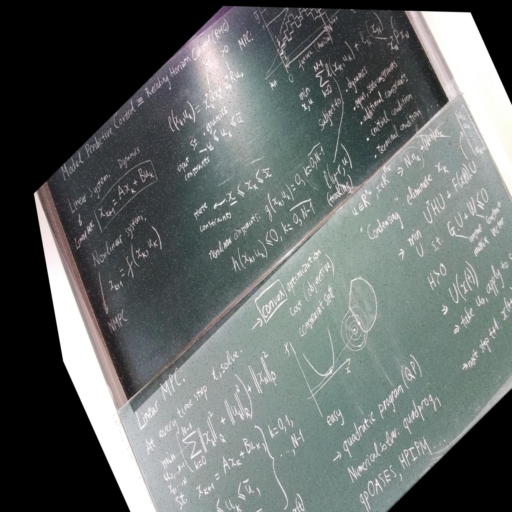

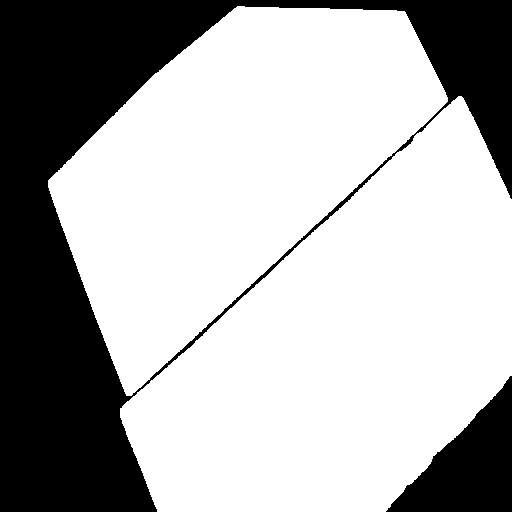

In [8]:
dataset = PNGMaskDataset("dataset/train")

img, mask = dataset[0]

img = tensor_to_pil(img)
mask = tensor_to_pil(mask * 255)

display(img)
display(mask)

del dataset, img, mask

## FeynMAN Model Definition

In [5]:
# Import needed libs

import torch
import torch.nn as nn

In [6]:
import torch
import torch.nn as nn

from torch import Tensor

class FeynMAN(nn.Module):
    def __init__(self, in_channels: int = 3, num_classes: int = 2):
        super(__class__, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x: torch.Tensor) -> Tensor:
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

# Training

In [8]:
!nvidia-smi && echo "YES YOU CAN TRAIN WITH CUDA!"

Mon Aug 28 20:19:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 8
DATASET_DIR = "dataset/train/"

In [8]:
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim

def train_model(
    model: nn.Module,
    dataset_dir: str = DATASET_DIR,
    epochs: int = EPOCHS,
    batch_size: int = BATCH_SIZE,
    learning_rate: float = LEARNING_RATE,
    device: torch.device = torch.device("cpu"),
):
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="feynman_2",

        # track hyperparameters and run metadata
        config={
        "learning_rate": learning_rate,
        "epochs": epochs,
        "batch_size": batch_size,
        "architecture": "FeynMAN",
        "dataset": "feynman_v7i",
        }
    )

    # Watch the model for cool weights & biases
    wandb.watch(model)

    # criterion = nn.CrossEntropyLoss() # nn.BCELoss() #### TODO: change?
    criterion = nn.BCELoss()
    params = model.parameters()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    dataset = PNGMaskDataset(dataset_dir)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print("BEGIN TRAINING!")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        print(epoch)

        for batch_idx, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device) #.float()
            print("#", batch_idx)

            # Forward pass
            outputs = model(images)
            print("post forward pass")
            loss = criterion(outputs, masks)
            print("loss done")

            # Backpropagation and optimization
            optimizer.zero_grad()
            print("zero grad done")
            loss.backward()
            print("backward done")
            optimizer.step()
            print("step done")

            running_loss += loss.item()
            wandb.log({"Loss": loss})

            print(
                f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx+1}/{len(dataloader)}] - Loss: {loss:.4f}"
            )

        wandb.log({"Running loss": running_loss})

    print("END TRAINING!")
    wandb.finish()

### Model creation

In [9]:
model = FeynMAN()
device_type = "cuda" if torch.cuda.is_available() else "cpu"
#device_type = "cpu"
device = torch.device(device_type)

# Put the model on the GPU
model = model.to(device)

#### Debug

In [ ]:
# Test the input etc.

input_height = 256
input_width = 256
random_input = torch.randn(1, 3, input_height, input_width)

# Forward pass
segmentation_map = model(random_input)
print("Segmentation map shape:", segmentation_map.shape)

Segmentation map shape: torch.Size([1, 3, 256, 256])


In [ ]:
from torchviz import make_dot

ds = PNGMaskDataset("./dataset/test/")
x_tmp, _ = ds[0]
x_tmp = x_tmp.to(device)
y_tmp = model(x_tmp.unsqueeze(0))

make_dot(y_tmp, params=dict(list(model.named_parameters()))).render("model.png", format="png")

del model, ds, x_tmp, y_tmp, _

In [ ]:
!pip install torchsummary


model = model.to(device)

from torchsummary import summary
summary(model, input_size=(3, 128, 128), batch_size=8, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 128, 128]           1,792
              ReLU-2          [8, 64, 128, 128]               0
            Conv2d-3         [8, 128, 128, 128]          73,856
              ReLU-4         [8, 128, 128, 128]               0
            Conv2d-5         [8, 256, 128, 128]         295,168
              ReLU-6         [8, 256, 128, 128]               0
            Conv2d-7           [8, 3, 128, 128]             771
Total params: 371,587
Trainable params: 371,587
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.50
Forward/backward pass size (MB): 899.00
Params size (MB): 1.42
Estimated Total Size (MB): 901.92
----------------------------------------------------------------


### Start training loop

#### FCN ResNet 50 test

In [13]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(num_classes=3, pretrained=False)
model = model.to(device)

#### Train the model

In [10]:
# Fix for some CUDA bullshit

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [11]:
print(f"Doing training on device type '{device_type}'!")
torch.cuda.empty_cache()
train_model(model, dataset_dir="./dataset/train/", device=device, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, epochs=EPOCHS)

Doing training on device type 'cuda'!


BEGIN TRAINING!
0
# 0
post forward pass
loss done
zero grad done


RuntimeError: ignored